# Predict tags on StackOverflow with linear models

We will learn how to predict tags for posts from [StackOverflow](https://stackoverflow.com). To solve this task you will use multilabel classification approach.

### Libraries

In this task you will need the following libraries:
- [Numpy](http://www.numpy.org) — a package for scientific computing.
- [Pandas](https://pandas.pydata.org) — a library providing high-performance, easy-to-use data structures and data analysis tools for the Python
- [scikit-learn](http://scikit-learn.org/stable/index.html) — a tool for data mining and data analysis.
- [NLTK](http://www.nltk.org) — a platform to work with natural language.

### Data


#### Text preprocessing

In this task we will deal with a dataset of post titles from StackOverflow. Datasets is splited into 3 sets: *train*, *validation* and *test*. All corpora (except for *test*) contain titles of the posts and corresponding tags (100 tags are available).

In [1]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chait\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
from ast import literal_eval
import pandas as pd
import numpy as np

In [3]:
def read_data(filename):
    data = pd.read_csv(filename, sep='\t')
    data['tags'] = data['tags'].apply(literal_eval)
    return data

In [4]:
train = read_data('data/train.tsv')
validation = read_data('data/validation.tsv')
test = pd.read_csv('data/test.tsv', sep='\t')

In [5]:
validation.head()

,title,tags
0,Why odbc_exec always fail?,"[php, sql]"
1,Access a base classes variable from within a c...,[javascript]
2,"Content-Type ""application/json"" not required i...","[ruby-on-rails, ruby]"
3,Sessions in Sinatra: Used to Pass Variable,"[ruby, session]"
4,"Getting error - type ""json"" does not exist - i...","[ruby-on-rails, ruby, json]"


As you can see, *title* column contains titles of the posts and *tags* column contains the tags. It could be noticed that a number of tags for a post is not fixed and could be as many as necessary.

For a more comfortable usage, initialize *X_train*, *X_val*, *X_test*, *y_train*, *y_val*.

In [6]:
X_train, y_train = train['title'].values, train['tags'].values
X_val, y_val = validation['title'].values, validation['tags'].values
X_test = test['title'].values

One of the most known difficulties when working with natural data is that it's unstructured. For example, if you use it "as is" and extract tokens just by splitting the titles by whitespaces, you will see that there are many "weird" tokens like *3.5?*, *"Flip*, etc. To prevent the problems, it's usually useful to prepare the data somehow.

In [7]:
import re

In [8]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def text_prepare(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower()
    text = re.sub(REPLACE_BY_SPACE_RE," ",text)
    text = re.sub(BAD_SYMBOLS_RE,"",text)
    text = text.split();
    return ' '.join([i for i in text if i not in STOPWORDS])

Now we can preprocess the titles using function *text_prepare* and  making sure that the headers don't have bad symbols:

In [9]:
X_train = [text_prepare(x) for x in X_train]
X_val = [text_prepare(x) for x in X_val]
X_test = [text_prepare(x) for x in X_test]

In [10]:
X_train[:3]

['draw stacked dotplot r',
 'mysql select records datetime field less specified value',
 'terminate windows phone 81 app']

For each tag and for each word calculate how many times they occur in the train corpus. 

In [11]:
from collections import defaultdict
# Dictionary of all tags from train corpus with their counts.
tags_counts =  defaultdict(int)
# Dictionary of all words from train corpus with their counts.
words_counts =  defaultdict(int)

In [12]:
for text in X_train:
    for word in text.split():
        words_counts[word] += 1


for tags in y_train:
    for tag in tags:
        tags_counts[tag] += 1

### Transforming text to a vector

Machine Learning algorithms work with numeric data and we cannot use the provided text data "as is". There are many ways to transform text data to numeric vectors. In this task you will try to use two of them.

#### Bag of words

One of the well-known approaches is a *bag-of-words* representation. To create this transformation, follow the steps:
1. Find *N* most popular words in train corpus and numerate them. Now we have a dictionary of the most popular words.
2. For each title in the corpora create a zero vector with the dimension equals to *N*.
3. For each text in the corpora iterate over words which are in the dictionary and increase by 1 the corresponding coordinate.

Let's try to do it for a toy example. Imagine that we have *N* = 4 and the list of the most popular words is 

    ['hi', 'you', 'me', 'are']

Then we need to numerate them, for example, like this: 

    {'hi': 0, 'you': 1, 'me': 2, 'are': 3}

And we have the text, which we want to transform to the vector:

    'hi how are you'

For this text we create a corresponding zero vector 

    [0, 0, 0, 0]
    
And iterate over all words, and if the word is in the dictionary, we increase the value of the corresponding position in the vector:

    'hi':  [1, 0, 0, 0]
    'how': [1, 0, 0, 0] # word 'how' is not in our dictionary
    'are': [1, 0, 0, 1]
    'you': [1, 1, 0, 1]

The resulting vector will be 

    [1, 1, 0, 1]
   
Described encoding in the function *my_bag_of_words* with the size of the dictionary equals to 5000. To find the most common words use train data.

In [13]:
most_common_words = sorted(words_counts.items(), key=lambda x: x[1], reverse=True)[:6000]
DICT_SIZE = 5000
WORDS_TO_INDEX = {p[0]:i for i,p in enumerate(most_common_words[:DICT_SIZE])} ####### YOUR CODE HERE #######
INDEX_TO_WORDS = {WORDS_TO_INDEX[k]:k for k in WORDS_TO_INDEX}####### YOUR CODE HERE #######
ALL_WORDS = WORDS_TO_INDEX.keys()

def my_bag_of_words(text, words_to_index, dict_size):
    """
        text: a string
        dict_size: size of the dictionary
        
        return a vector which is a bag-of-words representation of 'text'
    """
    
    result_vector = np.zeros(dict_size)
    for word in text.split():
        if word in words_to_index:
            result_vector[words_to_index[word]] += 1
    
    return result_vector

Now appling the implemented function to all samples:

In [14]:
from scipy import sparse as sp_sparse

In [15]:
X_train_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_train])
X_val_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_val])
X_test_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_test])
print('X_train shape ', X_train_mybag.shape)
print('X_val shape ', X_val_mybag.shape)
print('X_test shape ', X_test_mybag.shape)

X_train shape  (100000, 5000)
X_val shape  (30000, 5000)
X_test shape  (20000, 5000)


we transform the data to sparse representation, to store the useful information efficiently. There are many [types](https://docs.scipy.org/doc/scipy/reference/sparse.html) of such representations, however sklearn algorithms can work only with [csr](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html#scipy.sparse.csr_matrix) matrix, so we will use this one.

#### TF-IDF

The second approach extends the bag-of-words framework by taking into account total frequencies of words in the corpora. It helps to penalize too frequent words and provide better features space. 

Function *tfidf_features* using class [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) from *scikit-learn*. Using *train* corpus to train a vectorizer.

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [17]:
def tfidf_features(X_train, X_val, X_test):
    """
        X_train, X_val, X_test — samples        
        return TF-IDF vectorized representation of each sample and vocabulary
    """
    tfidf_vectorizer = TfidfVectorizer(min_df=5, max_df=0.9, ngram_range=(1, 2),
                                       token_pattern='(\S+)')  
    X_train=tfidf_vectorizer.fit_transform(X_train)
    X_val=tfidf_vectorizer.transform(X_val)
    X_test=tfidf_vectorizer.transform(X_test)
                                       
    return X_train, X_val, X_test, tfidf_vectorizer.vocabulary_

Once we have done text preprocessing, always have a look at the results. Be very careful at this step, because the performance of future models will drastically depend on it. 

In this case, check whether you have c++ or c# in your vocabulary, as they are obviously important tokens in our tags prediction task:

In [18]:
X_train_tfidf, X_val_tfidf, X_test_tfidf, tfidf_vocab = tfidf_features(X_train, X_val, X_test)
tfidf_reversed_vocab = {i:word for word,i in tfidf_vocab.items()}

In [19]:
tfidf_vocab['c++']

1976

If you can't find it, we need to understand how did it happen that we lost them? It happened during the built-in tokenization of TfidfVectorizer. Luckily, we can influence on this process. Get back to the function above and use '(\S+)' regexp as a *token_pattern* in the constructor of the vectorizer.  

Now, use this transormation for the data and check again.

In [20]:
tfidf_reversed_vocab[1976]

'c++'

### MultiLabel classifier

We have noticed before, in this task each example can have multiple tags. To deal with such kind of prediction, we need to transform labels in a binary form and the prediction will be a mask of 0s and 1s. For this purpose it is convenient to use [MultiLabelBinarizer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MultiLabelBinarizer.html) from *sklearn*.

In [21]:
from sklearn.preprocessing import MultiLabelBinarizer

In [22]:
mlb = MultiLabelBinarizer(classes=sorted(tags_counts.keys()))
y_train = mlb.fit_transform(y_train)
y_val = mlb.fit_transform(y_val)

Function *train_classifier* for training a classifier.We use One-vs-Rest approach, which is implemented in [OneVsRestClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html) class. In this approach *k* classifiers (= number of tags) are trained. As a basic classifier, use [LogisticRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). It is one of the simplest methods, but often it performs good enough in text classification tasks. It might take some time, because a number of classifiers to train is large.

In [23]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition.nmf import NMF
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier

C:\Users\chait\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.decomposition.nmf module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.decomposition. Anything that cannot be imported from sklearn.decomposition is now part of the private API.
  warnings.warn(message, FutureWarning)


In [24]:
def train_classifier(X_train, y_train, C=1.0, penalty='l2'):
    """
      X_train, y_train — training data
      
      return: trained classifier
    """
    
    lr = LogisticRegression(solver='newton-cg',C=C, penalty=penalty,n_jobs=-1)
    # lr.fit(X_train, y_train)
    ovr = OneVsRestClassifier(lr)
    ovr.fit(X_train, y_train)
    return ovr

Training the classifiers for different data transformations: *bag-of-words* and *tf-idf*.

In [25]:
classifier_mybag = train_classifier(X_train_mybag, y_train)
classifier_tfidf = train_classifier(X_train_tfidf, y_train)

Now you can create predictions for the data. You will need two types of predictions: labels and scores.

In [26]:
y_val_predicted_labels_mybag = classifier_mybag.predict(X_val_mybag)
y_val_predicted_scores_mybag = classifier_mybag.decision_function(X_val_mybag)

y_val_predicted_labels_tfidf = classifier_tfidf.predict(X_val_tfidf)
y_val_predicted_scores_tfidf = classifier_tfidf.decision_function(X_val_tfidf)

Now take a look at how classifier, which uses TF-IDF, works for a few examples:

In [30]:
y_val_pred_inversed = mlb.inverse_transform(y_val_predicted_labels_tfidf)
y_val_inversed = mlb.inverse_transform(y_val)

lis = [25, 14, 75]

for i in lis:
    print('Title:\t{}\nTrue labels:\t {}\nPredicted labels: {}\n\n'.format(
        X_val[i],
        ','.join(y_val_inversed[i]),
        ','.join(y_val_pred_inversed[i])
    ))

Title:	stop disable internet access java
True labels:	 java
Predicted labels: java


Title:	dynamic data matrix wpf
True labels:	 c#,wpf
Predicted labels: c#,wpf


Title:	set entity doctrine database view symfony 2
True labels:	 mysql,php
Predicted labels: php




Now, we would need to compare the results of different predictions, e.g. to see whether TF-IDF transformation helps or to try different regularization techniques in logistic regression. For all these experiments, we need to setup evaluation procedure. 

### Evaluation

To evaluate the results we will use several classification metrics:
 - [Accuracy](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)
 - [F1-score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html)
 - [Area under ROC-curve](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html)
 - [Area under precision-recall curve](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html#sklearn.metrics.average_precision_score) 
 
Make sure you are familiar with all of them. How would you expect the things work for the multi-label scenario? Read about micro/macro/weighted averaging following the sklearn links provided above.

In [31]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score

Implement the function *print_evaluation_scores* which calculates and prints to stdout:
 - *accuracy*
 - *F1-score macro/micro/weighted*
 - *Precision macro/micro/weighted*

In [32]:
def print_evaluation_scores(y_val, predicted):
    
    print(accuracy_score(y_val, predicted))
    print(f1_score(y_val, predicted, average='weighted'))
    print(average_precision_score(y_val, predicted))

In [33]:
print('Bag-of-words')
print_evaluation_scores(y_val, y_val_predicted_labels_mybag)
print('Tfidf')
print_evaluation_scores(y_val, y_val_predicted_labels_tfidf)

Bag-of-words
0.3578
0.6486667031464047
0.3444038613007691
Tfidf
0.33393333333333336
0.6142668931088263
0.30181976655232984


You might also want to plot some generalization of the [ROC curve](http://scikit-learn.org/stable/modules/model_evaluation.html#receiver-operating-characteristic-roc) for the case of multi-label classification. Provided function *roc_auc* can make it for you. The input parameters of this function are:
 - true labels
 - decision functions scores
 - number of classes

In [34]:
from metrics import roc_auc
%matplotlib inline

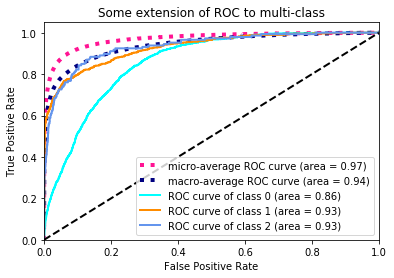

In [35]:
n_classes = len(tags_counts)
roc_auc(y_val, y_val_predicted_scores_mybag, n_classes)

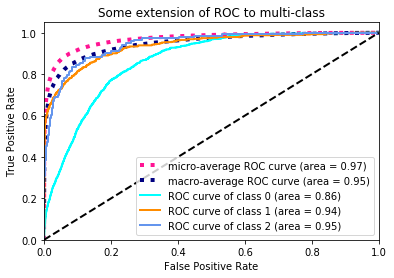

In [36]:
n_classes = len(tags_counts)
roc_auc(y_val, y_val_predicted_scores_tfidf, n_classes)

### Analysis of the most important features

Finally, it is usually a good idea to look at the features (words or n-grams) that are used with the largest weigths in your logistic regression model.

Function *print_words_for_tag* to find them. Get back to sklearn documentation on [OneVsRestClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html) and [LogisticRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) if needed.

In [37]:
def print_words_for_tag(classifier, tag, tags_classes, index_to_words, all_words):
    """
        classifier: trained classifier
        tag: particular tag
        tags_classes: a list of classes names from MultiLabelBinarizer
        index_to_words: index_to_words transformation
        all_words: all words in the dictionary
        
        return nothing, just print top 5 positive and top 5 negative words for current tag
    """
    print('Tag:\t{}'.format(tag))
    est = classifier.estimators_[tags_classes.index(tag)]
    top_positive_words = [index_to_words[index] for index in est.coef_.argsort().tolist()[0][-5:]]  # top-5 words sorted by the coefficiens.
    top_negative_words = [index_to_words[index] for index in est.coef_.argsort().tolist()[0][:5]] # bottom-5 words  sorted by the coefficients.
    print('Top positive words:\t{}'.format(', '.join(top_positive_words)))
    print('Top negative words:\t{}\n'.format(', '.join(top_negative_words)))

In [38]:
print_words_for_tag(classifier_tfidf, 'c', mlb.classes, tfidf_reversed_vocab, ALL_WORDS)
print_words_for_tag(classifier_tfidf, 'c++', mlb.classes, tfidf_reversed_vocab, ALL_WORDS)
print_words_for_tag(classifier_tfidf, 'linux', mlb.classes, tfidf_reversed_vocab, ALL_WORDS)

Tag:	c
Top positive words:	gcc, printf, scanf, malloc, c
Top negative words:	java, php, python, javascript, c#

Tag:	c++
Top positive words:	opencv, mfc, boost, qt, c++
Top negative words:	java, php, python, javascript, c#

Tag:	linux
Top positive words:	signal, address, c, ubuntu, linux
Top negative words:	javascript, c#, jquery, array, method

